## Create Dependencies

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import requests as rq
import random as rnd
import gmaps
import os
import io
import json
import time

# Import API key
#import config

# Configure gmaps
#gkey = config.gkey
#gmaps.configure(api_key=gkey)

## Create and set the path

In [2]:
notebook_path = os.getcwd()
parent_dir = notebook_path[0:-4]

## Store csv filenames. Iterate through the filename list and get csv from path and store in variables

In [3]:
dataset_filelist = ["1_county_level_confirmed_cases.csv","2_cases_and_deaths_by_county_timeseries.csv","weekly-claims-by-county-twc.csv","texas_county_med_income.csv"]
for csv in dataset_filelist:   
    for root, dirs, files in os.walk(parent_dir):
        if csv in files:
            if csv == dataset_filelist[0]:
                covid_dataset1 = (os.path.join(root, csv))
            elif csv == dataset_filelist[1]:
               covid_dataset2 =  (os.path.join(root, csv))
            elif csv == dataset_filelist[2]:
               unemployment_dataset =  (os.path.join(root, csv))
            else:
                texas_median_income = (os.path.join(root, csv))

## Use pandas and read contents of csv into a DataFrame

In [4]:
ConfirmedByCounty_Covid = pd.read_csv(covid_dataset1)
CaseDeathsBy_County_timeseries = pd.read_csv(covid_dataset2, parse_dates=['date'])
unemployment_dataset = pd.read_csv(unemployment_dataset)
texas_median_income = pd.read_csv(texas_median_income)

## Remove ("$",",") characters from the Texas Median Income dataset and convert to float

In [5]:
texas_median_income['Median Household Income'] = texas_median_income['Median Household Income'].str.replace('$','').str.replace(',','').astype(float)

In [6]:
texas_median_income.head()

,County,Median Household Income
0,Anderson,45969.0
1,Andrews,84946.0
2,Angelina,46653.0
3,Aransas,46912.0
4,Archer,61190.0


In [7]:
texas_low_income = texas_median_income.loc[(texas_median_income['Median Household Income'] > 57000)]
texas_low_income.describe()

,Median Household Income
count,56.000000
mean,69560.303571
std,11444.745846
min,57052.000000
25%,60789.500000
50%,66080.000000
75%,76322.000000
max,102858.000000


## Incomes that qualify as low imcome per HUD data. Less than or equal to 57K but greater than 36K

In [8]:
texas_low_income = texas_median_income.loc[(texas_median_income['Median Household Income'] <= 57000) & (texas_median_income['Median Household Income'] > 36000)]
texas_low_income.head()

,County,Median Household Income
0,Anderson,45969.0
2,Angelina,46653.0
3,Aransas,46912.0
6,Atascosa,50594.0
8,Bailey,45051.0


## Incomes that qualify as very low imcome per HUD data. Less than or equal to 36K but greater than 26K

In [9]:
texas_verylow_income = texas_median_income.loc[(texas_median_income['Median Household Income'] <= 36000) & (texas_median_income['Median Household Income'] > 26000)]
texas_verylow_income.head()

,County,Median Household Income
23,Brooks,30116.0
65,Duval,35156.0
95,Hall,32597.0
161,Maverick,35594.0
163,Menard,35881.0


## Covid-19 Dataset that gives most recent case and death numbers as of 2020-11-13
* Cleansed Data to get rid of one row in Latitude and Longitude that had NaN

In [10]:
Texas_ConfirmedByCounty_Covid = ConfirmedByCounty_Covid.loc[ConfirmedByCounty_Covid['state'] == 'Texas'].dropna(subset=['lat','lon'])
Texas_ConfirmedByCounty_Covid.head()

,last_update,location_type,state,county_name,county_name_long,fips_code,lat,lon,NCHS_urbanization,total_population,confirmed,confirmed_per_100000,deaths,deaths_per_100000
2599,2020-11-13 00:26:19 UTC,county,Texas,Anderson,"Anderson, Texas, US",48001.0,31.815347,-95.653548,Micropolitan,57863.0,3035,5245.15,42,72.59
2600,2020-11-13 00:26:19 UTC,county,Texas,Andrews,"Andrews, Texas, US",48003.0,32.304686,-102.637655,Micropolitan,17818.0,781,4383.21,11,61.74
2601,2020-11-13 00:26:19 UTC,county,Texas,Angelina,"Angelina, Texas, US",48005.0,31.254573,-94.609015,Micropolitan,87607.0,2380,2716.68,93,106.16
2602,2020-11-13 00:26:19 UTC,county,Texas,Aransas,"Aransas, Texas, US",48007.0,28.105562,-96.999505,Medium metro,24763.0,369,1490.13,18,72.69
2603,2020-11-13 00:26:19 UTC,county,Texas,Archer,"Archer, Texas, US",48009.0,33.615700,-98.687546,Small metro,8789.0,187,2127.66,1,11.38


In [11]:
Texas_ConfirmedByCounty_Covid = Texas_ConfirmedByCounty_Covid.drop(columns=["location_type","state","county_name_long","fips_code"])

In [12]:
covid_cumlative_groupby = Texas_ConfirmedByCounty_Covid.groupby('NCHS_urbanization')
covid_cumlative_groupby['county_name'].count()

NCHS_urbanization
Large central metro      6
Large fringe metro      29
Medium metro            25
Micropolitan            46
Non-core               126
Small metro             22
Name: county_name, dtype: int64

In [13]:
Texas_ConfirmedByCounty_Covid.loc[Texas_ConfirmedByCounty_Covid['NCHS_urbanization'] == 'Large central metro'].sort_values('total_population',ascending=False)

,last_update,county_name,lat,lon,NCHS_urbanization,total_population,confirmed,confirmed_per_100000,deaths,deaths_per_100000
2699,2020-11-13 00:26:19 UTC,Harris,29.858649,-95.393395,Large central metro,4602523.0,170835,3711.77,2877,62.51
2655,2020-11-13 00:26:19 UTC,Dallas,32.766706,-96.777960,Large central metro,2586552.0,105377,4074.03,1341,51.85
2818,2020-11-13 00:26:19 UTC,Tarrant,32.771438,-97.291016,Large central metro,2019977.0,78029,3862.87,892,44.16
2613,2020-11-13 00:26:19 UTC,Bexar,29.449287,-98.520197,Large central metro,1925865.0,68376,3550.40,1438,74.67
2825,2020-11-13 00:26:19 UTC,Travis,30.334320,-97.785356,Large central metro,1203166.0,33769,2806.68,462,38.40
2641,2020-11-13 00:26:19 UTC,Collin,33.188201,-96.572644,Large central metro,944350.0,20888,2211.89,205,21.71


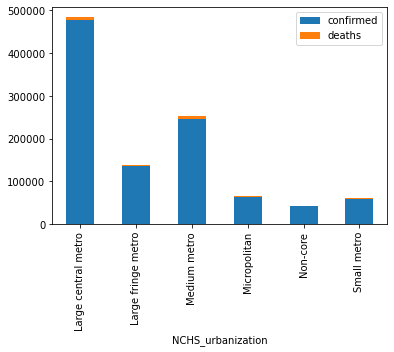

In [14]:
combined = covid_cumlative_groupby['confirmed','deaths'].sum()
combined.plot(kind='bar', stacked=True)

In [15]:
urban_death = covid_cumlative_groupby['deaths'].mean()

In [16]:
urban_death

NCHS_urbanization
Large central metro    1202.500000
Large fringe metro       77.310345
Medium metro            230.520000
Micropolitan             40.739130
Non-core                  9.595238
Small metro              53.227273
Name: deaths, dtype: float64

In [17]:
urban_cases.plot.bar()

NameError: name 'urban_cases' is not defined

In [17]:
covid_cumlative_groupby['confirmed'].mean()

NCHS_urbanization
Large central metro    79545.666667
Large fringe metro      4714.862069
Medium metro            9861.880000
Micropolitan            1375.391304
Non-core                 326.746032
Small metro             2680.727273
Name: confirmed, dtype: float64

## Select only data related to the state of Texas and drop all column with headers starting with "new"

In [18]:
columns_todrop = []
Texas_CaseDeathsBy_County_timeseries = CaseDeathsBy_County_timeseries.loc[(CaseDeathsBy_County_timeseries['state'] == 'Texas') & (CaseDeathsBy_County_timeseries['location_name'] != 'Unassigned') & (CaseDeathsBy_County_timeseries['location_name'] != 'Out of TX')]
Texas_CaseDeathsBy_County_timeseries = Texas_CaseDeathsBy_County_timeseries.loc[Texas_CaseDeathsBy_County_timeseries['date'] >= '2020-03-01']
for column in Texas_CaseDeathsBy_County_timeseries.columns:
    if column.startswith('new'):
        columns_todrop.append(column)
for drop in columns_todrop:
    Texas_CaseDeathsBy_County_timeseries = Texas_CaseDeathsBy_County_timeseries.drop(columns=drop)
Texas_CaseDeathsBy_County_timeseries.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000
767924,84048001,county,48001.0,Anderson,Texas,2020-03-01,57863.0,0,0.0,0,0.0
767925,84048001,county,48001.0,Anderson,Texas,2020-03-02,57863.0,0,0.0,0,0.0
767926,84048001,county,48001.0,Anderson,Texas,2020-03-03,57863.0,0,0.0,0,0.0
767927,84048001,county,48001.0,Anderson,Texas,2020-03-04,57863.0,0,0.0,0,0.0
767928,84048001,county,48001.0,Anderson,Texas,2020-03-05,57863.0,0,0.0,0,0.0


## Drop all other unused columns

In [19]:
Texas_CaseDeathsBy_County_timeseries = Texas_CaseDeathsBy_County_timeseries.drop(columns=["uid","location_type","state"]).set_index('date')

In [115]:
Texas_CaseDeathsBy_County_timeseries

,fips_code,location_name,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000
date,,,,,,,
2020-03-01,48001.0,Anderson,57863.0,0,0.00,0,0.00
2020-03-02,48001.0,Anderson,57863.0,0,0.00,0,0.00
2020-03-03,48001.0,Anderson,57863.0,0,0.00,0,0.00
2020-03-04,48001.0,Anderson,57863.0,0,0.00,0,0.00
2020-03-05,48001.0,Anderson,57863.0,0,0.00,0,0.00
...,...,...,...,...,...,...,...
2020-11-11,48507.0,Zavala,12131.0,498,4105.19,20,164.87
2020-11-12,48507.0,Zavala,12131.0,498,4105.19,21,173.11
2020-11-13,48507.0,Zavala,12131.0,501,4129.92,21,173.11


In [20]:
unemployment_claims = unemployment_dataset.copy()
unemployment_claims = unemployment_claims.transpose()
unemployment_claims = unemployment_claims.fillna(0)

In [21]:
unemployment_claims.columns = [''] * len(unemployment_claims.columns)
unemployment_header = unemployment_claims.iloc[0]
unemployment_claims = unemployment_claims[1:]
unemployment_claims.columns = unemployment_header
unemployment_claims.index.names = ['Date']
unemployment_claims.columns.names = ['']

In [118]:
unemployment_claims

,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
Date,,,,,,,,,,,,,,,,,,,,,
10/31/2020,42,17,77,32,3,1,46,28,3,23,...,24,422,28,7,74,31,14,16,20,11
10/24/2020,79,17,89,22,6,0,36,23,1,13,...,51,409,34,8,65,33,8,17,27,18
10/17/2020,54,17,80,40,5,1,35,26,4,24,...,43,434,30,15,45,26,6,17,27,12
10/10/2020,63,30,98,18,10,2,40,32,3,11,...,24,484,41,11,57,38,6,19,22,16
10/3/2020,64,25,103,26,6,1,55,37,5,18,...,15,574,41,12,79,45,9,11,19,16
9/26/2020,64,21,100,35,5,1,56,30,4,22,...,26,564,39,18,59,46,7,18,29,11
9/19/2020,61,18,119,25,4,0,70,29,3,25,...,23,526,42,13,59,29,5,7,23,21
9/12/2020,66,32,107,31,5,0,67,42,8,4,...,19,524,41,8,51,56,12,13,23,20
9/5/2020,85,22,171,50,6,3,96,45,9,41,...,29,800,54,19,86,83,10,22,34,18


In [22]:
locations = Texas_ConfirmedByCounty_Covid[['lat','lon']]
confirmed = Texas_ConfirmedByCounty_Covid['confirmed']

In [23]:
zero_coor = (31.81,-95.65)
figure_layout = {'width': '1050px', 'margin': '0 auto 0 auto'}
# Plot Heatmap
fig = gmaps.figure(center=zero_coor,zoom_level=5.5,layout=figure_layout,map_type="TERRAIN")

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=confirmed,
                                 dissipating=False, max_intensity=.5,
                                 point_radius=.5)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px', margin='0 auto 0 auto', width='1050px'))

In [4]:
## COVID-19 in Low Income Communities



In [55]:
#combined_low = texas_median_income.loc[(texas_median_income['Median Household Income'] < 57000)]
COPY_TXCaseDeathsBy_County_timeseries = Texas_CaseDeathsBy_County_timeseries.rename(columns={"location_name": "County"})
#COPY_TXCaseDeathsBy_County_timeseries

index = Texas_CaseDeathsBy_County_timeseries.index.values
combined_low_covidcases = pd.merge(texas_low_income, COPY_TXCaseDeathsBy_County_timeseries, on='County', how='outer').set_index(index)
combined_low_covidcases = combined_low_covidcases.dropna(how='any')

#keep last day of month for every low income county to keep most recent cumulative cases per 100,000
clean_combined_low_covidcases = combined_low_covidcases[(combined_low_covidcases.index + pd.Timedelta(days=1)).day == 1]
test2 = combined_low_covidcases.loc['2020-11-11']
clean_combined_low_covidcases = clean_combined_low_covidcases.append(test2)
COPY_date_list = ['2020-03-31','2020-04-30','2020-05-31','2020-06-30','2020-07-31','2020-08-31','2020-09-30','2020-10-31','2020-11-11']
clean_combined_low_covidcases


,County,Median Household Income,fips_code,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000
2020-03-31,Anderson,45969.0,48001.0,57863.0,1,1.73,0,0.00
2020-04-30,Anderson,45969.0,48001.0,57863.0,29,50.12,0,0.00
2020-05-31,Anderson,45969.0,48001.0,57863.0,72,124.43,0,0.00
2020-06-30,Anderson,45969.0,48001.0,57863.0,1032,1783.52,2,3.46
2020-07-31,Anderson,45969.0,48001.0,57863.0,2196,3795.17,8,13.83
...,...,...,...,...,...,...,...,...
2020-11-11,Wichita,47477.0,48485.0,131818.0,4966,3767.32,74,56.14
2020-11-11,Wilbarger,44735.0,48487.0,12906.0,470,3641.72,6,46.49
2020-11-11,Winkler,56781.0,48495.0,7802.0,180,2307.10,5,64.09
2020-11-11,Wood,48384.0,48499.0,43815.0,722,1647.84,44,100.42


In [64]:
# sort data by month for low income counties
march_low_covidcases = clean_combined_low_covidcases['2020-03-31']
march_sum_low_covidcases = march_low_covidcases['cumulative_cases_per_100_000'].sum()

april_low_covidcases = clean_combined_low_covidcases['2020-04-30']
april_sum_low_covidcases = april_low_covidcases['cumulative_cases_per_100_000'].sum()

may_low_covidcases = clean_combined_low_covidcases['2020-05-31']
may_sum_low_covidcases = may_low_covidcases['cumulative_cases_per_100_000'].sum()

june_low_covidcases = clean_combined_low_covidcases['2020-06-30']
june_sum_low_covidcases = june_low_covidcases['cumulative_cases_per_100_000'].sum()

july_low_covidcases = clean_combined_low_covidcases['2020-07-31']
july_sum_low_covidcases = july_low_covidcases['cumulative_cases_per_100_000'].sum()

aug_low_covidcases = clean_combined_low_covidcases['2020-08-31']
aug_sum_low_covidcases = aug_low_covidcases['cumulative_cases_per_100_000'].sum()

sept_low_covidcases = clean_combined_low_covidcases['2020-09-30']
sept_sum_low_covidcases = sept_low_covidcases['cumulative_cases_per_100_000'].sum()

oct_low_covidcases = clean_combined_low_covidcases['2020-10-31']
oct_sum_low_covidcases = oct_low_covidcases['cumulative_cases_per_100_000'].sum()

nov_low_covidcases = clean_combined_low_covidcases['2020-11-11']
nov_sum_low_covidcases = nov_low_covidcases['cumulative_cases_per_100_000'].sum()

low_months_sum = [march_sum_low_covidcases, april_sum_low_covidcases, may_sum_low_covidcases, june_sum_low_covidcases, july_sum_low_covidcases, aug_sum_low_covidcases, sept_sum_low_covidcases, oct_sum_low_covidcases, nov_sum_low_covidcases]
low_months_sum

[1181.54,
 13406.490000000002,
 36542.08,
 79858.9,
 236946.05,
 338508.16,
 423752.04999999993,
 545157.22,
 613727.74]

In [58]:
#keep last day of month for every very low income county to keep most recent cumulative cases per 100,000
combined_verylow_covidcases = pd.merge(texas_verylow_income, COPY_TXCaseDeathsBy_County_timeseries, on='County', how='outer').set_index(index)
combined_verylow_covidcases = combined_verylow_covidcases.dropna(how='any')

clean_combined_verylow_covidcases = combined_verylow_covidcases[(combined_verylow_covidcases.index + pd.Timedelta(days=1)).day == 1]
test2_verylow = combined_verylow_covidcases.loc['2020-11-11']
clean_combined_verylow_covidcases = clean_combined_verylow_covidcases.append(test2_verylow)
clean_combined_verylow_covidcases

,County,Median Household Income,fips_code,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000
2020-03-31,Brooks,30116.0,48047.0,7180.0,0,0.00,0,0.00
2020-04-30,Brooks,30116.0,48047.0,7180.0,1,13.93,0,0.00
2020-05-31,Brooks,30116.0,48047.0,7180.0,1,13.93,0,0.00
2020-06-30,Brooks,30116.0,48047.0,7180.0,3,41.78,0,0.00
2020-07-31,Brooks,30116.0,48047.0,7180.0,84,1169.92,1,13.93
...,...,...,...,...,...,...,...,...
2020-11-11,Menard,35881.0,48327.0,2123.0,85,4003.77,1,47.10
2020-11-11,Starr,30490.0,48427.0,63894.0,3649,5711.02,187,292.67
2020-11-11,Willacy,33171.0,48489.0,21754.0,1280,5883.98,59,271.21
2020-11-11,Zapata,33160.0,48505.0,14369.0,384,2672.42,9,62.63


In [65]:
# sort data by month for very low income counties
march_verylow_covidcases = clean_combined_verylow_covidcases['2020-03-31']
march_sum_verylow_covidcases = march_verylow_covidcases['cumulative_cases_per_100_000'].sum()

april_verylow_covidcases = clean_combined_verylow_covidcases['2020-04-30']
april_sum_verylow_covidcases = april_verylow_covidcases['cumulative_cases_per_100_000'].sum()

may_verylow_covidcases = clean_combined_verylow_covidcases['2020-05-31']
may_sum_verylow_covidcases = may_verylow_covidcases['cumulative_cases_per_100_000'].sum()

june_verylow_covidcases = clean_combined_verylow_covidcases['2020-06-30']
june_sum_verylow_covidcases = june_verylow_covidcases['cumulative_cases_per_100_000'].sum()

july_verylow_covidcases = clean_combined_verylow_covidcases['2020-07-31']
july_sum_verylow_covidcases = july_verylow_covidcases['cumulative_cases_per_100_000'].sum()

aug_verylow_covidcases = clean_combined_verylow_covidcases['2020-08-31']
aug_sum_verylow_covidcases = aug_verylow_covidcases['cumulative_cases_per_100_000'].sum()

sept_verylow_covidcases = clean_combined_verylow_covidcases['2020-09-30']
sept_sum_verylow_covidcases = sept_verylow_covidcases['cumulative_cases_per_100_000'].sum()

oct_verylow_covidcases = clean_combined_verylow_covidcases['2020-10-31']
oct_sum_verylow_covidcases = oct_verylow_covidcases['cumulative_cases_per_100_000'].sum()

nov_verylow_covidcases = clean_combined_verylow_covidcases['2020-11-11']
nov_sum_verylow_covidcases = nov_verylow_covidcases['cumulative_cases_per_100_000'].sum()

verylow_months_sum = [march_sum_verylow_covidcases, april_sum_verylow_covidcases, may_sum_verylow_covidcases, june_sum_verylow_covidcases, july_sum_verylow_covidcases, aug_sum_verylow_covidcases, sept_sum_verylow_covidcases, oct_sum_verylow_covidcases, nov_sum_verylow_covidcases]
verylow_months_sum

[14.05,
 203.75,
 601.6299999999999,
 3431.06,
 14893.779999999999,
 24756.14,
 33401.55,
 39628.48,
 41791.37]

In [ ]:
#keep last day of month for all other income county to keep most recent cumulative cases per 100,000
#combined_other_covidcases = pd.merge(texas_verylow_income, COPY_TXCaseDeathsBy_County_timeseries, on='County', how='outer').set_index(index)
#combined_verylow_covidcases = combined_verylow_covidcases.dropna(how='any')

#clean_combined_verylow_covidcases = combined_verylow_covidcases[(combined_verylow_covidcases.index + pd.Timedelta(days=1)).day == 1]
#test2_verylow = combined_verylow_covidcases.loc['2020-11-11']
#clean_combined_verylow_covidcases = clean_combined_verylow_covidcases.append(test2_verylow)
#clean_combined_verylow_covidcases

In [67]:
texas_median_income

,County,Median Household Income
0,Anderson,45969.0
1,Andrews,84946.0
2,Angelina,46653.0
3,Aransas,46912.0
4,Archer,61190.0
...,...,...
249,Wood,48384.0
250,Yoakum,61560.0
251,Young,49301.0
252,Zapata,33160.0


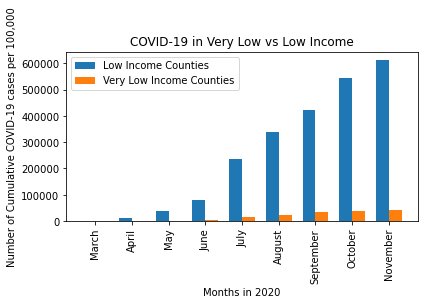

In [69]:
#plt.scatter(COPY_date_list, low_months_sum, c='red', marker='o', edgecolors='black' )
#plt.bar(COPY_date_list, low_months_sum)
low_verylow_month_labels = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']
#low_months_sum
#verylow_months_sum

x = np.arange(len(low_verylow_month_labels)) #the label locations
width = 0.35 #width of the bars

fig, ax = plt.subplots()
low_bar = ax.bar(x - width/2, low_months_sum, width, label='Low Income Counties')
verylow_bar = ax.bar(x + width/2, verylow_months_sum, width, label='Very Low Income Counties')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Cumulative COVID-19 cases per 100,000')
ax.set_xlabel('Months in 2020')
ax.set_title('COVID-19 in Very Low vs Low Income')
ax.set_xticks(x)
ax.set_xticklabels(low_verylow_month_labels)
plt.xticks(rotation='vertical')
ax.legend()

fig.tight_layout()

plt.show()
#plt.savefig('low_vs_verylow_income.png')

In [95]:
%reset